In [5]:
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from snf import *

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath    

In [6]:
with open('pickles/LRRPred_validation.pickle', 'rb') as handle:
    LRR_d = pickle.load(handle)

df = pd.read_excel('FileS1.xlsx', skiprows = 9)
pdbl = PDBList()
code_l = []
for ii in range(df.shape[0]):
    if ii%2:
        code = df.iloc[ii]['PDB ID + chain']
        code_l.append(code)


In [34]:
# io = PDBIO()
# for code, val in LRR_d.items():
#     locs,chain = val
#     io.set_structure(chain)
#     io.save(make_path('pdb', 'validation_chains', code+'.pdb'))

In [10]:
code = code_l[4]
motifLocs = LRR_d[code]

parser = PDBParser()
structure = parser.get_structure(code, "pdb/validation_chains/%s.pdb"%code)

chain = list(structure.get_chains())[0]


csvpath = make_path('csv', 'validation', '%s.csv'%code)
alpha_carbons = []
for atom in chain.get_atoms():
    if atom.id == 'CA':
        alpha_carbons.append(np.array(list(atom.get_vector())))
        
X = np.array(alpha_carbons)
np.savetxt(csvpath, X, delimiter=',')

#print out the number of residues in the chain, and print the locations of the LRR motif residues
print(X.shape[0])
print(motifLocs)

463
[45, 67, 89, 111, 133, 155, 176, 198, 220, 242]


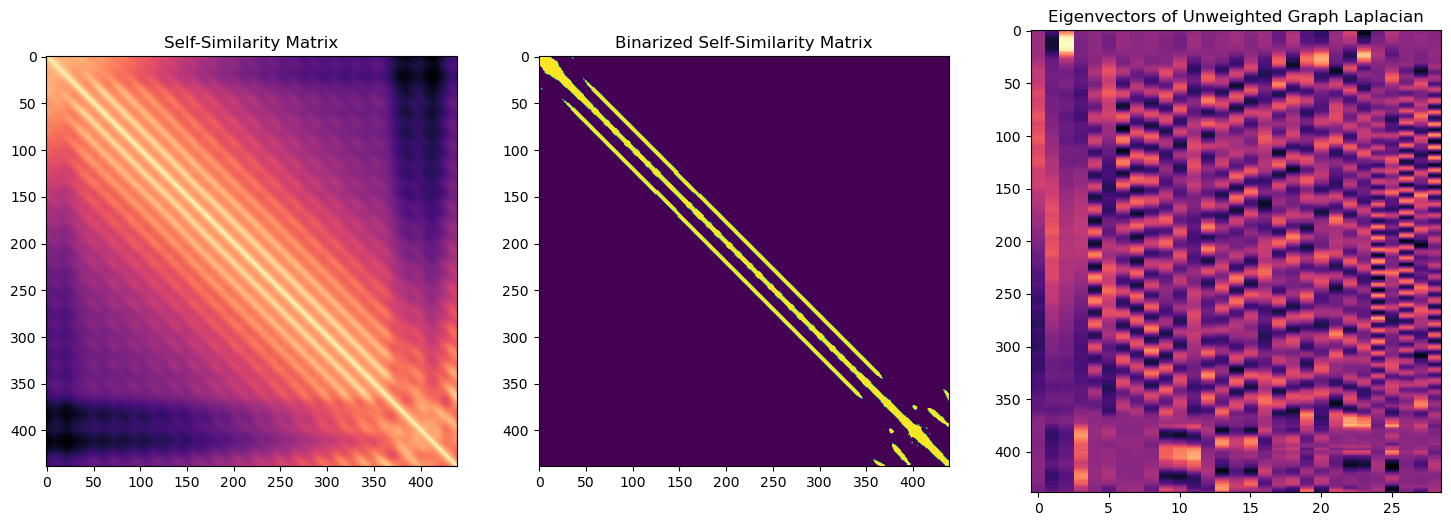

In [11]:
if __name__ == '__main__':
    readFromFile = False
    if readFromFile:
        fin = open(csvpath)
        X = [[float(f) for f in line.split(",")] for line in fin.readlines()]
        X = np.array(X)
    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    period = 25
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 20)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(D, cmap='magma_r')
    plt.title("Self-Similarity Matrix")
    plt.subplot(132)
    plt.imshow(B)
    plt.title("Binarized Self-Similarity Matrix")
    plt.subplot(133)
    plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
    plt.title("Eigenvectors of Unweighted Graph Laplacian")
    plt.show()

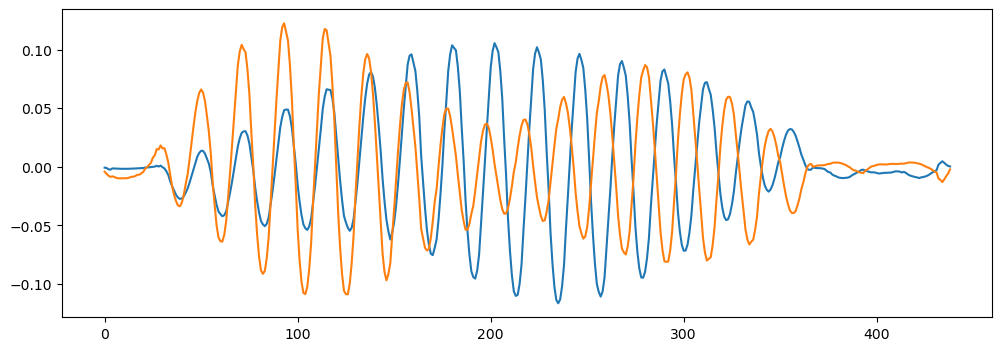

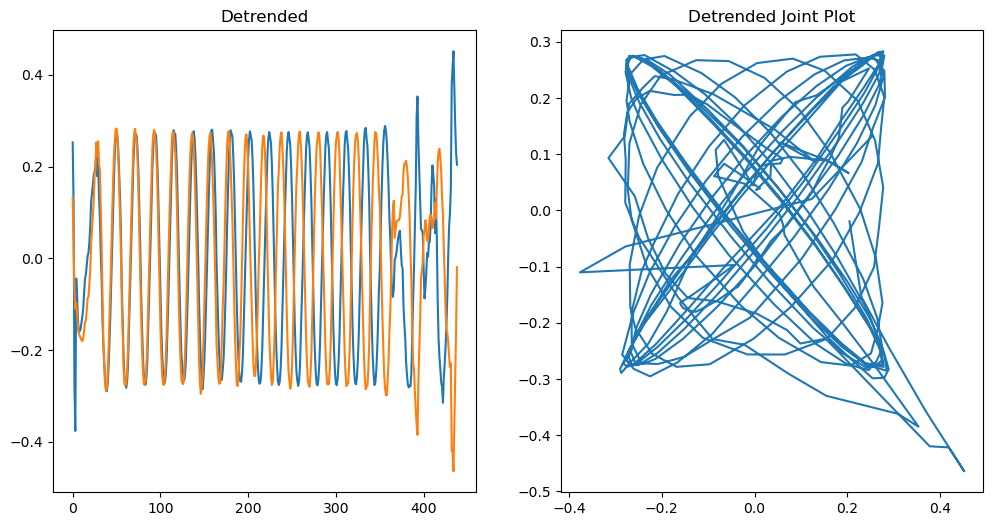

0



/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_42107/3485565096.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(res, theta[res], 'bo', color='red')


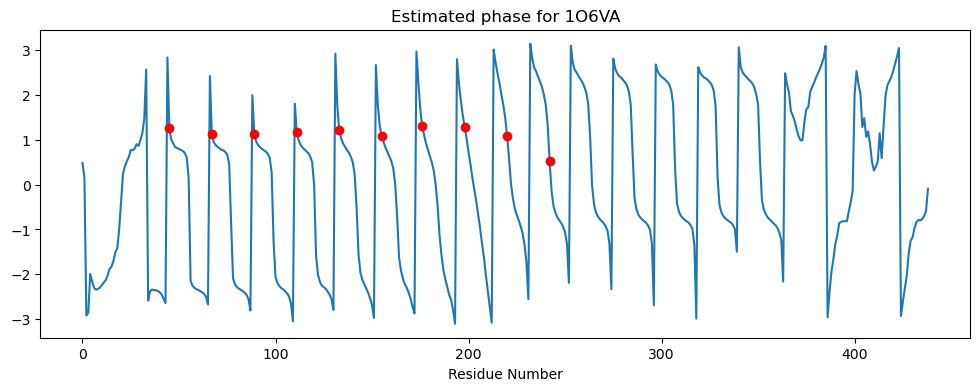

<function matplotlib.pyplot.close(fig=None)>

In [12]:
# I can see the signal in the 5th and 6th eigenvectors
# but it needs to be demodulated
plt.figure(figsize=(12, 4))
s = v[:,4]
c = v[:, 6]
plt.plot(s)
plt.plot(c)
plt.show()
from daps import *
# Detrend with daps
sf = detrend_timeseries(s, period)
cf = detrend_timeseries(c, period)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sf)
plt.plot(cf)
plt.title("Detrended")
plt.subplot(122)
plt.title("Detrended Joint Plot")
plt.plot(sf, cf)
plt.show()


# Extract the final phase and plot

theta = np.arctan2(cf, sf)
plt.figure(figsize=(12, 4))
plt.plot(theta)

omitted = 0
for res in motifLocs:
    if res < len(theta):
        plt.plot(res, theta[res], 'bo', color='red')                  
    else:
        omitted += 1
print(omitted)        


plt.title("Estimated phase for %s" %code)
plt.xlabel("Residue Number")
plt.savefig(make_path('plots','validation/%s.png'%code))
print()

plt.show()
plt.close

/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


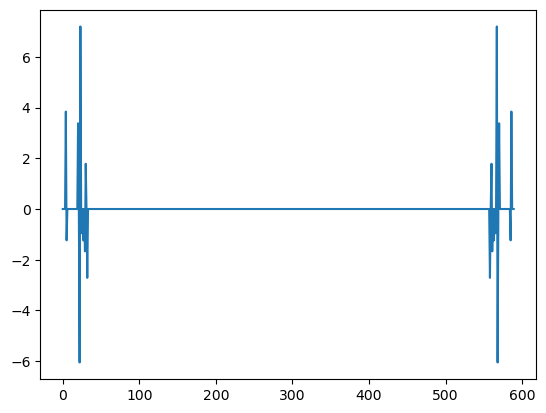

In [19]:
plt.plot((np.abs(f) > cutoff).astype('float')*f)

In [23]:
from numpy.fft import fft
from numpy.linalg import norm

fft_l = []
g_l = []
freqCutoff = 100
for ii in range(20):
    s = v[:, ii]
    cutoff = norm(s)*1500/len(s)
    f = fft(s)
    fft_l.append(f)
    g = (np.abs(f) > cutoff).astype('float')*np.abs(f)
    g_l.append(g[:freqCutoff])
    
    if False:
        plt.plot(g[:freqCutoff])
        plt.title('eigenvector: '+str(ii) +f' cutoff:{cutoff}')#+f' {norm(f - g)}')
        plt.show()
        plt.close()

In [33]:
first_pass = []
for jj, g in enumerate(g_l):
    support = []
    for ii, val in enumerate(g):
        if val:
            support.append(ii)
    if set(support).intersection(range(22, 28)):
        first_pass.append((jj, support))



In [48]:
lowFreqCutoff = 5
intersec = lambda tup: set(tup[1]).intersection(range(lowFreqCutoff))
min_intersection = min([len(intersec(tup)) for tup in first_pass])
second_pass = filter(lambda x: len(intersec(x)) == min_intersection, first_pass)
second_pass = sorted(second_pass, key = lambda tup: len(tup[1]))
for supp in second_pass:
    print(supp)

# sorted(first_pass, key=)

(4, [24, 25, 26, 27])
(6, [23, 24, 25, 26, 27])
(7, [22, 23, 24, 25, 26, 27, 28])
(16, [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])


[1, 2, 3]


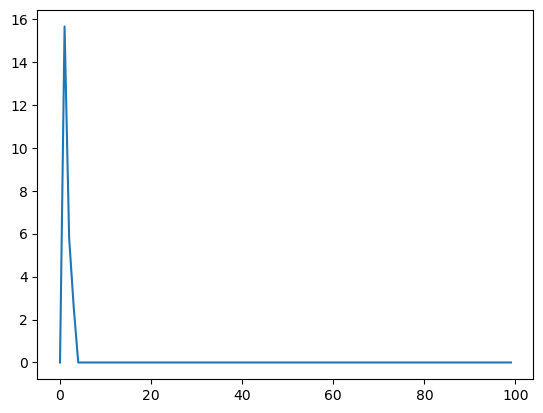

In [27]:
print(support)
plt.plot(g_l[])

0


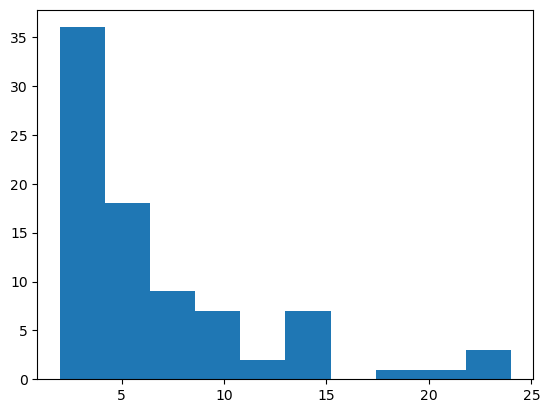

1


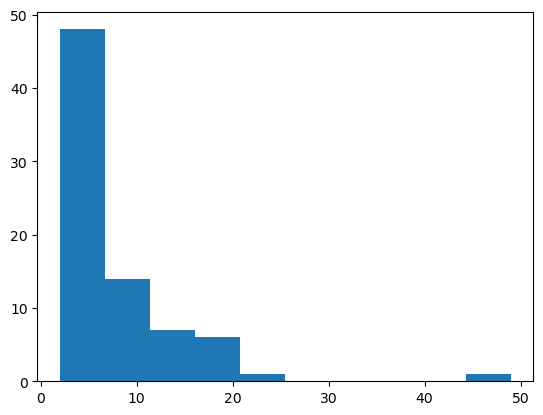

2


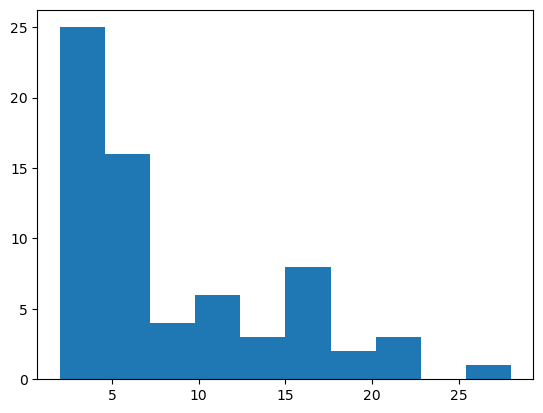

3


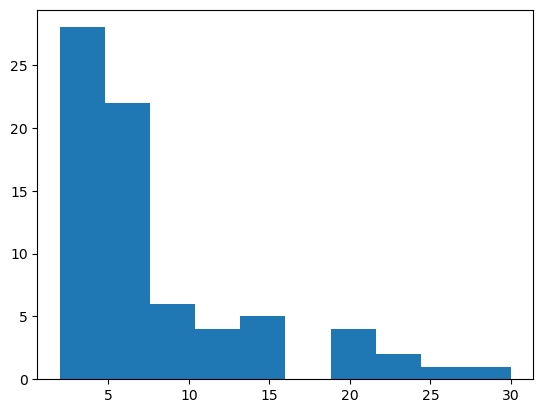

4


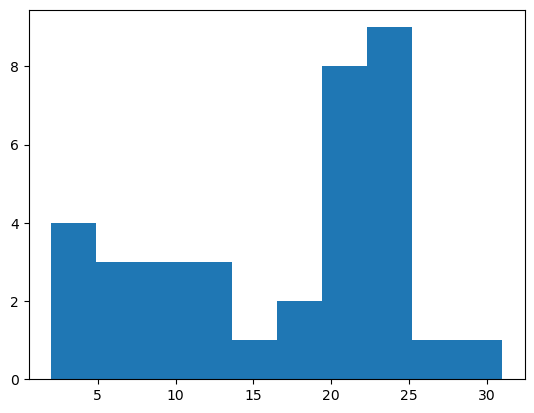

5


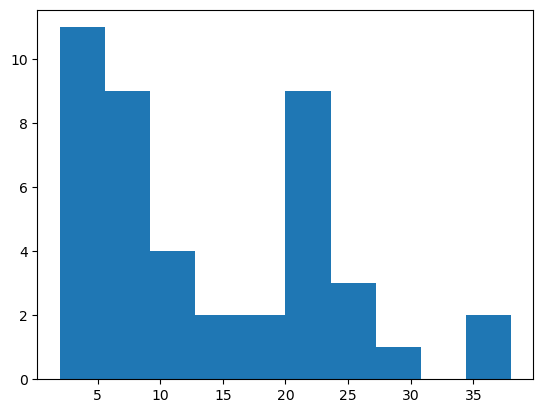

6


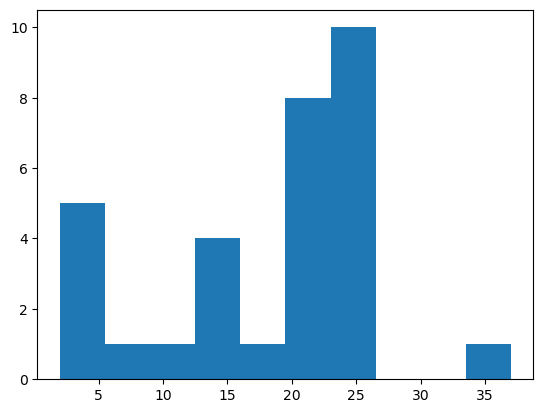

7


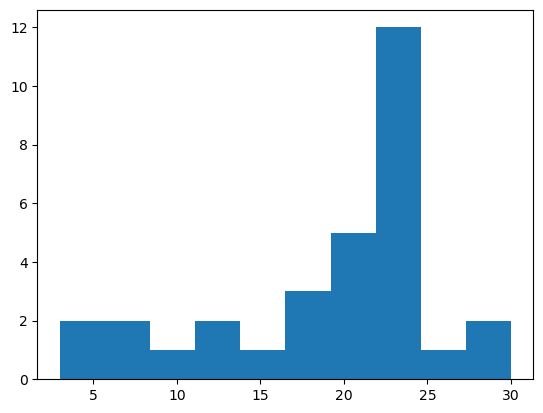

8


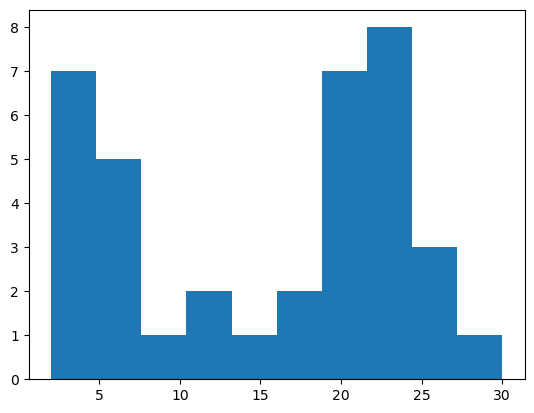

9


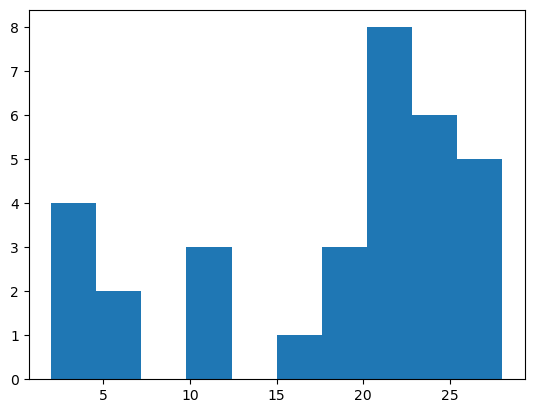

10


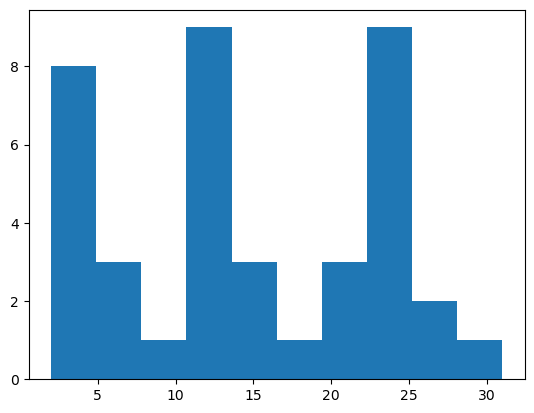

11


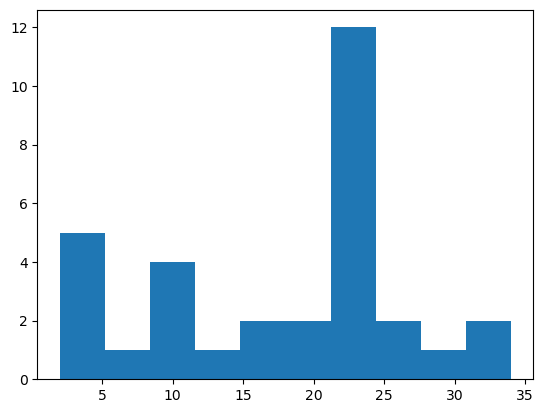

12


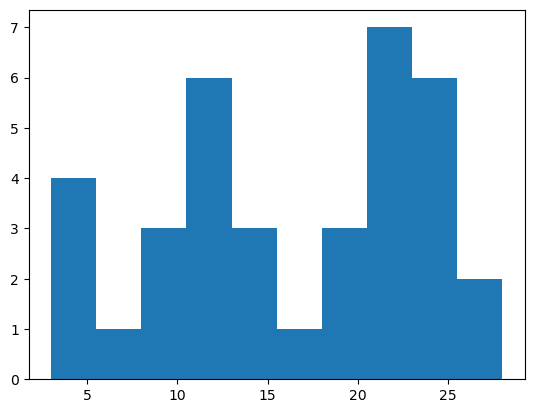

13


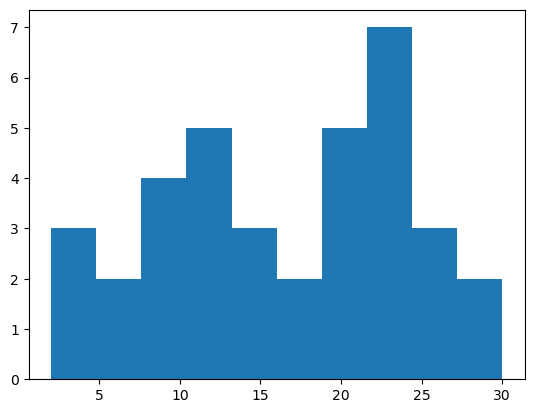

14


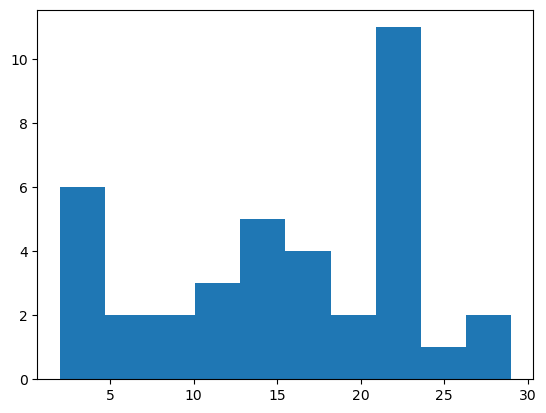

15


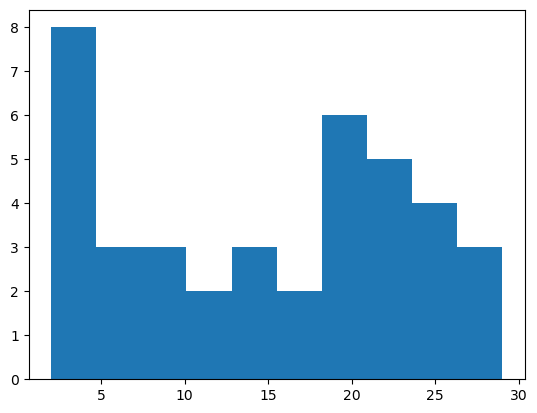

16


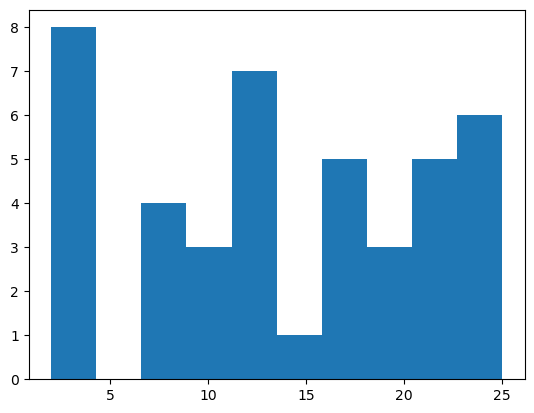

17


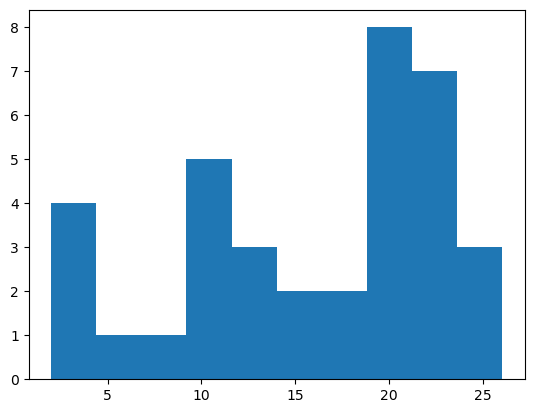

18


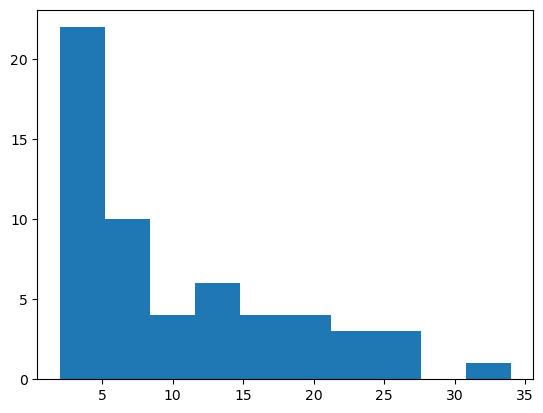

19


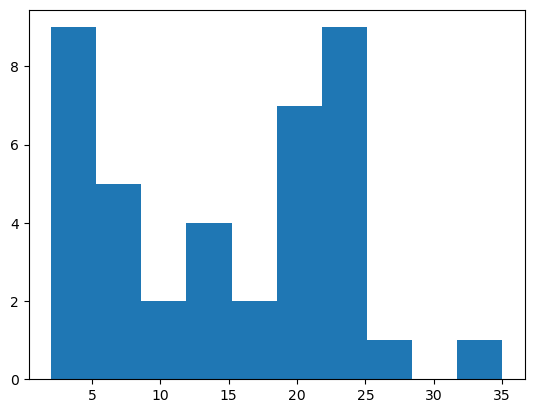

20


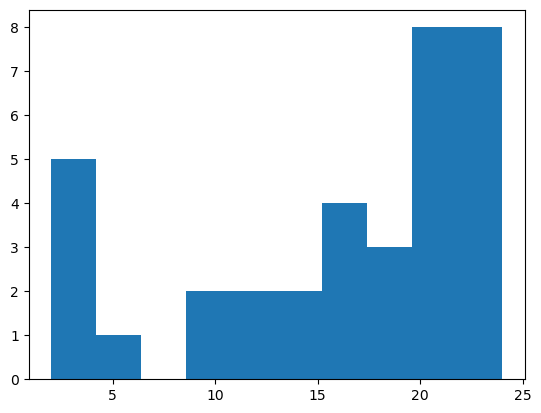

21


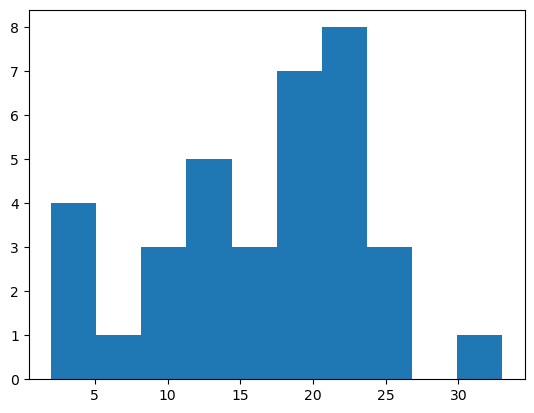

22


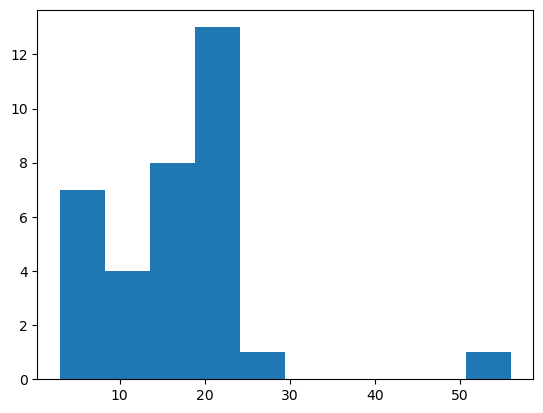

23


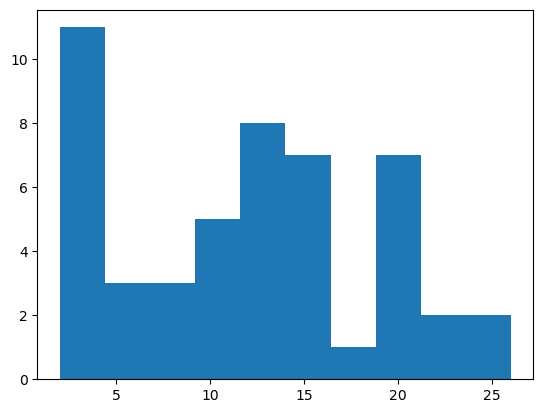

24


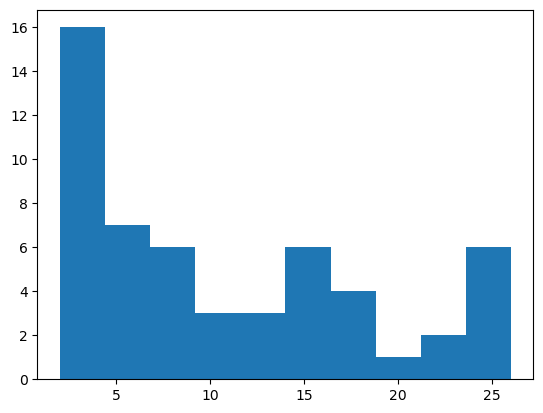

25


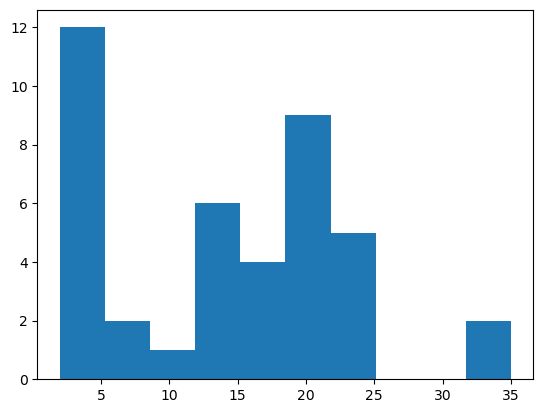

26


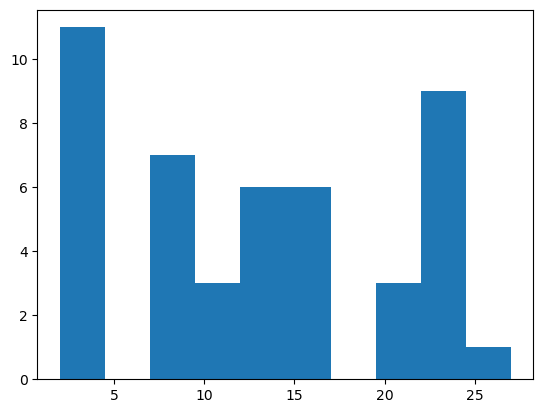

27


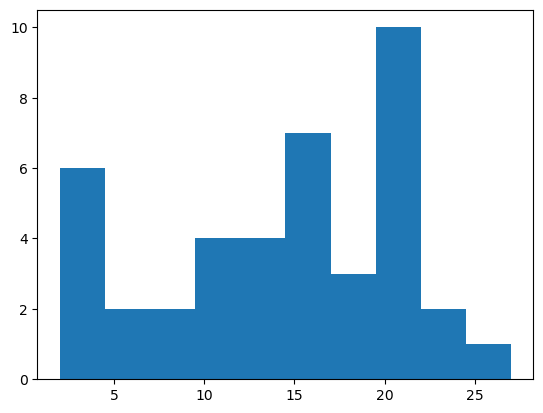

28


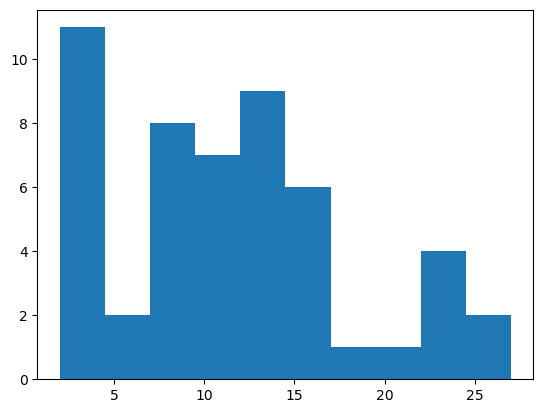

In [37]:
for ii in range(29):
    s = v[:,ii]

    # lb_thresh = 5
    x = []

    allpeaks, properties = scipy.signal.find_peaks(s, prominence = 0)
    for prevargpeak, argpeak, lb in zip(allpeaks[:-1], allpeaks[1:], properties['left_bases']):
        x.append(argpeak - prevargpeak)
        # if argpeak - lb > lb_thresh:            
            # break
        # print(argpeak, lb)
    print(ii)
    plt.hist(x)  
    plt.show()
    plt.close()

In [108]:
for ii in range(29):
    s = v[:,ii]
    lb_thresh = 5
    allpeaks, properties = scipy.signal.find_peaks(s, prominence = 0) 
    heights = []
    args = []
    peaks = []
    for argpeak, lb in zip(allpeaks, properties['left_bases']):
        if argpeak-lb > 5:
            peaks.append(s[argpeak])
            heights.append(s[argpeak]-s[lb])
            args.append(argpeak)
            # print(argpeak, lb)

    #peak height ratios
    # for arg, prevheight, height in zip(args, heights[:-1], heights[1:]):
    #     print(arg, height/prevheight)    
    peakargs, properties = scipy.signal.find_peaks(peaks, prominence = 0)
    print([(args[peakarg], args[lb], s[args[peakarg]]) for peakarg, lb in zip(peakargs, properties['left_bases']) if args[peakarg] - args[lb] > 40])

[(169, 8, 0.0649264399967446), (499, 391, -0.001730656021754204)]
[(267, 57, 0.08876722341596241), (499, 412, -0.0051550892178521416)]
[(146, 27, 0.04986845151807386), (401, 281, 0.05776222498547153)]
[(307, 176, 0.05332590841926987), (502, 412, -0.0060308164124154105)]
[(217, 23, 0.12174298487947213), (421, 353, 0.021404985138156134), (526, 485, 0.004436138376911882)]
[(227, 112, 0.09353043446105025), (424, 338, 0.05986655297930336)]
[(154, 29, 0.10233674885260091), (527, 475, 0.0031530133363481083)]
[(114, 11, 0.11681605575117945), (290, 202, 0.09411224809522917)]
[(119, 20, 0.09241363194702215), (316, 209, 0.10526830223598292)]
[(195, 112, 0.05626731476054353), (388, 286, 0.13660773008435728)]
[(83, 27, 0.02318652893265809), (259, 187, 0.017987169636395274), (464, 356, 0.08736971258759092), (542, 356, 0.1595356358628595)]
[(224, 178, 0.049742512614711375), (394, 313, 0.11910182952042776), (546, 458, 0.0424305873230439)]
[(174, 88, 0.07749562287713731), (379, 88, 0.12366386802680558)

In [70]:
peakargs, properties = scipy.signal.find_peaks(peaks, prominence = 0)


In [73]:
peaks

[0.014352026124438377,
 0.02262686146712628,
 0.029564487765846463,
 0.04029920023753266,
 0.05516771001685417,
 0.07699882303847486,
 0.09464598589741495,
 0.11289034372477995,
 0.12174298487947213,
 0.12149080250382777,
 0.10498150454956914,
 0.07604425033692266,
 0.04243351029396932,
 0.017327453632150373,
 0.010504578174087334,
 0.015156954274504517,
 0.019576562665316204,
 0.021404985138156134,
 0.018163277552417704,
 0.0020590518659709873,
 0.0025210724572315955,
 0.0043816874220089334,
 0.004436138376911882,
 0.0041448510425314,
 -0.0004131164637465935]

In [101]:
[(args[peakarg], args[lb], s[args[peakarg]]) for peakarg, lb in zip(peakargs, properties['left_bases'])]

[(119, 20, -0.019427209844988504),
 (316, 209, -0.019389982283499925),
 (537, 513, 0.0024544242487380364)]

540 -0.024348944930863717
539 -0.024348944930863717
538 -0.03350477623608854
537 -0.03350477623608854
536 -0.04044762140363245
535 -0.04044762140363245
534 -0.04044762140363245
533 -0.04044762140363245
532 -0.04044762140363245
531 -0.04044762140363245
530 -0.04044762140363245
529 -0.04044762140363245
528 -0.04044762140363245
527 -0.04044762140363245
526 -0.04044762140363245
525 -0.04044762140363245
524 -0.04044762140363245
523 -0.04044762140363245
522 -0.04044762140363245
521 -0.04044762140363245
520 -0.04044762140363245
519 -0.04428063603197996
518 -0.04428063603197996
517 -0.04428063603197996
516 -0.04428063603197996
515 -0.04428063603197996
514 -0.04428063603197996
513 -0.04428063603197996
512 -0.04044762140363245
511 -0.04044762140363245
510 -0.03350477623608854
509 -0.03350477623608854
508 -0.03350477623608854
507 -0.03350477623608854
506 -0.03350477623608854
505 -0.03350477623608854
504 -0.03350477623608854
503 -0.03350477623608854
502 -0.03350477623608854
501 -0.0335047762360885

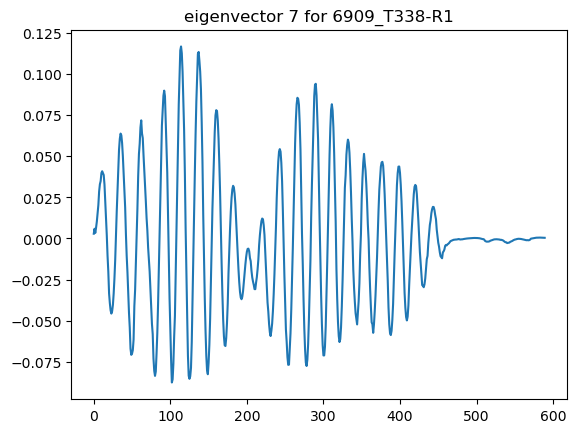

In [49]:
s = v[:,7]

windowSize = 50
maxShift = 50
period_l =[]
lb_thresh = 5
bufferSize = windowSize + maxShift+2
for ii in range(D.shape[0]-windowSize , bufferSize, -1):
    pair=[]
    for shift in range(maxShift):
        sig = s[ii:ii+windowSize]
        shift_sig = s[ii-shift:ii-shift+windowSize]
        try:
            pair.append(np.dot(sig, shift_sig))
        except:
            print(ii)
            raise Exception('')
    allpeaks, properties = scipy.signal.find_peaks(np.array(pair), prominence = 0)
    for argpeak, lb in zip(allpeaks, properties['left_bases']):
        if argpeak - lb > lb_thresh:            
            break
    print(ii, argpeak, lb)
    # plt.plot(pair)
    # break

In [ ]:
s = v[:,7]
plt.plot(s)
plt.title('eigenvector 7 for %s'% protid)
windowSize = 50
maxShift = 50
period_l =[]
lb_thresh = 5
bufferSize = windowSize + maxShift+2
for ii in range(D.shape[0]-windowSize , bufferSize, -1):
    pair=[]
    for shift in range(maxShift):
        sig = s[ii:ii+windowSize]
        shift_sig = s[ii-shift:ii-shift+windowSize]
        try:
            pair.append(np.dot(sig, shift_sig))
        except:
            print(ii)
            raise Exception('')
    allpeaks, properties = scipy.signal.find_peaks(np.array(pair), prominence = 0)
    for argpeak, lb in zip(allpeaks, properties['left_bases']):
        if argpeak - lb > lb_thresh:            
            break
    print(ii, argpeak, lb)
    # plt.plot(pair)
    # break

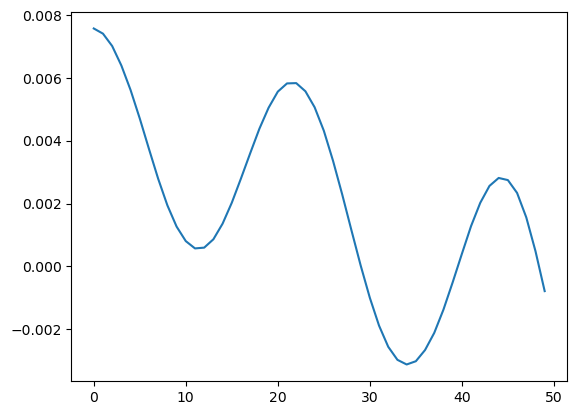

In [ ]:
ii = 440
pair=[]
for shift in range(maxShift):
    sig = s[ii-windowSize:ii]
    shift_sig = s[ii-shift-windowSize:ii-shift]
    try:
        pair.append(np.dot(sig, shift_sig))
    except:
        print(ii)
        raise Exception('')

plt.plot(pair)        

In [ ]:
windowSize = 50
maxShift = 50
period_l =[]
lb_thresh = 5
bufferSize = windowSize + maxShift+2
for ii in range(D.shape[0]-windowSize , bufferSize, -1):
    pair=[]
    for shift in range(maxShift):
        sig = s[ii:ii+windowSize]
        shift_sig = s[ii-shift:ii-shift+windowSize]
        try:
            pair.append(np.dot(sig, shift_sig))
        except:
            print(ii)
            raise Exception('')
    allpeaks, properties = scipy.signal.find_peaks(np.array(pair), prominence = 0)
    for argpeak, lb in zip(allpeaks, properties['left_bases']):
        if argpeak - lb > lb_thresh:            
            break
    print(ii, argpeak, lb)

540 28 18
539 28 19
538 27 20
537 26 20
536 25 20
535 24 20
534 5 0
533 5 0
532 5 0
531 5 0
530 5 0
529 5 0
528 4 0
527 4 0
526 34 31
525 35 30
524 35 29
523 34 28
522 34 27
521 34 26
520 34 25
519 34 24
518 33 23
517 32 23
516 32 22
515 31 22
514 30 21
513 29 21
512 29 21
511 27 21
510 26 20
509 25 21
508 23 22
507 23 22
506 23 22
505 23 22
504 23 22
503 23 22
502 23 22
501 23 22
500 32 31
499 34 30
498 35 29
497 39 28
496 42 27
495 42 27
494 42 27
493 42 27
492 48 25
491 47 25
490 47 24
489 46 23
488 46 22
487 45 22
486 45 21
485 44 21
484 43 20
483 44 20
482 43 20
481 43 19
480 43 18
479 43 18
478 42 17
477 43 16
476 43 16
475 43 15
474 43 14
473 43 14
472 44 14
471 44 13
470 44 13
469 44 13
468 44 12
467 45 12
466 45 11
465 45 10
464 44 9
463 44 7
462 44 6
461 24 4
460 21 0
459 20 0
458 17 0
457 16 0
456 15 0
455 14 0
454 13 0
453 12 0
452 11 0
451 10 0
450 9 0
449 8 0
448 7 0
447 6 0
446 29 17
445 28 16
444 27 16
443 27 15
442 26 14
441 25 14
440 25 13
439 24 13
438 24 12
437 23 1

In [ ]:
windowSize = 50
maxShift = 50
period_l =[]
lb_thresh = 5
bufferSize = windowSize + maxShift+2
s = v[:, 5]
for ii in range(D.shape[0]-windowSize , bufferSize, -1):
    pair=[]
    for shift in range(maxShift):
        sig = s[ii:ii+windowSize]
        shift_sig = s[ii-shift:ii-shift+windowSize]
        try:
            pair.append(np.dot(sig, shift_sig))
        except:
            print(ii)
            raise Exception('')
    allpeaks, properties = scipy.signal.find_peaks(np.array(pair), prominence = 0)
    for argpeak, lb in zip(allpeaks, properties['left_bases']):
        if argpeak - lb > lb_thresh:            
            break
    print(ii, argpeak, lb)

540 31 16
539 31 16
538 31 16
537 31 16
536 31 17
535 31 17
534 31 17
533 31 17
532 31 18
531 31 18
530 31 18
529 31 18
528 32 18
527 34 18
526 34 18
525 35 18
524 34 18
523 34 18
522 34 18
521 34 18
520 34 18
519 34 18
518 33 18
517 33 18
516 33 17
515 32 17
514 32 17
513 31 17
512 31 16
511 31 16
510 30 16
509 30 15
508 29 15
507 29 15
506 29 15
505 29 15
504 29 15
503 35 16
502 36 18
501 37 20
500 37 22
499 37 22
498 38 22
497 38 22
496 37 22
495 37 21
494 36 21
493 35 21
492 34 21
491 33 22
490 32 22
489 31 22
488 30 22
487 28 22
486 27 23
485 26 24
484 25 23
483 25 23
482 25 23
481 25 23
480 25 23
479 25 23
478 25 23
477 25 23
476 25 23
475 25 23
474 25 23
473 25 23
472 25 23
471 19 18
470 20 17
469 20 14
468 20 13
467 20 11
466 20 10
465 20 9
464 19 8
463 19 4
462 18 0
461 17 0
460 16 0
459 16 0
458 15 0
457 14 0
456 13 0
455 12 0
454 11 0
453 10 0
452 9 0
451 8 0
450 7 0
449 6 0
448 27 17
447 6 0
446 26 16
445 25 15
444 25 14
443 24 13
442 24 13
441 23 12
440 23 12
439 22 11
438

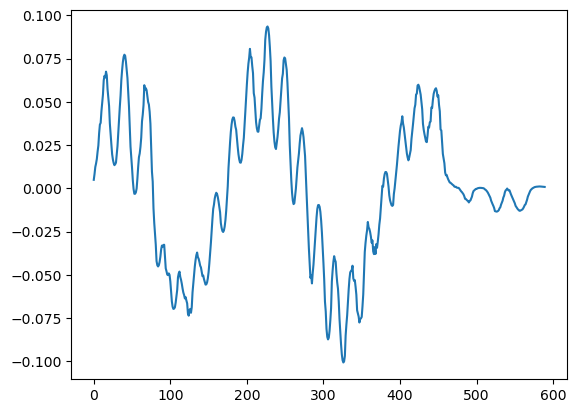

In [ ]:
plt.plot(s)

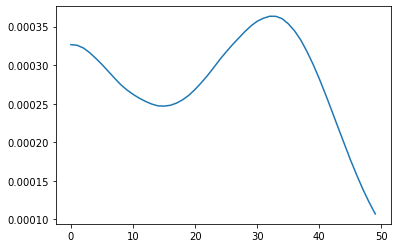

In [ ]:
plt.plot(pair)

In [ ]:
allPeaks, properties = scipy.signal.find_peaks(s, prominence = 6e-3)
prominences = properties['prominences']
for ii, argpeak in enumerate(allPeaks):
    if ii > 0:        
        if prominences[ii] < prominences[ii-1]*.05:
            print(argpeak, prominences[ii], ii)
            break

In [ ]:
scipy.signal.find_peaks(s, prominence = 0)

(array([  2,  23,  49,  80, 102, 125, 149, 172, 194, 217, 241, 265, 289,
        310, 332, 353, 364, 377, 399, 421, 444, 461, 471, 474, 485, 490,
        500, 524, 526, 536, 542, 556, 560, 564]),
 {'prominences': array([1.04987457e-03, 2.05725460e-02, 3.53783320e-02, 5.03309777e-02,
         8.39525919e-02, 1.24942012e-01, 1.61860980e-01, 1.84806546e-01,
         2.08724863e-01, 2.24300303e-01, 2.21443906e-01, 1.92022585e-01,
         1.50641463e-01, 1.04206724e-01, 5.79286077e-02, 3.31249631e-02,
         1.45380294e-03, 2.80487375e-02, 2.22855467e-02, 2.19206404e-02,
         1.39612298e-02, 1.50947367e-04, 5.60860862e-05, 1.59857214e-04,
         3.41168799e-05, 2.21102184e-03, 7.50137107e-06, 1.69186080e-06,
         4.49374160e-03, 5.07667111e-05, 1.44776908e-04, 1.98305879e-03,
         3.31446209e-05, 8.83840148e-07]),
  'left_bases': array([  1,  10,  35,  62,  92, 114, 137, 160, 183, 206, 230, 253, 277,
         300, 321, 344, 363, 344, 321, 321, 432, 460, 470, 470, 470, 470,


In [ ]:
scipy.signal.find_peaks(s, prominence = 0)[1]['prominences']

array([1.04987457e-03, 2.05725460e-02, 3.53783320e-02, 5.03309777e-02,
       8.39525919e-02, 1.24942012e-01, 1.61860980e-01, 1.84806546e-01,
       2.08724863e-01, 2.24300303e-01, 2.21443906e-01, 1.92022585e-01,
       1.50641463e-01, 1.04206724e-01, 5.79286077e-02, 3.31249631e-02,
       1.45380294e-03, 2.80487375e-02, 2.22855467e-02, 2.19206404e-02,
       1.39612298e-02, 1.50947367e-04, 5.60860862e-05, 1.59857214e-04,
       3.41168799e-05, 2.21102184e-03, 7.50137107e-06, 1.69186080e-06,
       4.49374160e-03, 5.07667111e-05, 1.44776908e-04, 1.98305879e-03,
       3.31446209e-05, 8.83840148e-07])

In [ ]:
np.log(6e-03)

-5.115995809754082

In [ ]:
import ckwrap
km = ckwrap.ckmeans(np.log(scipy.signal.find_peaks(s, prominence = 0)[1]['prominences']),2)
for prom, lab in zip(scipy.signal.find_peaks(s, prominence = 0)[1]['prominences'], km.labels):
    print(prom, lab)

0.001049874574666012 0
0.02057254603416681 1
0.035378331962416715 1
0.05033097771466018 1
0.08395259191001432 1
0.12494201172356083 1
0.16186098038903318 1
0.18480654589694806 1
0.20872486349247965 1
0.22430030290929157 1
0.22144390614144843 1
0.19202258534321517 1
0.1506414633800962 1
0.10420672420361002 1
0.057928607745363875 1
0.0331249631233569 1
0.0014538029350265706 1
0.028048737540783665 1
0.022285546672164574 1
0.021920640427637732 1
0.01396122984942746 1
0.00015094736651357276 0
5.608608616291036e-05 0
0.0001598572135168674 0
3.4116879888494364e-05 0
0.00221102184177398 1
7.501371067579205e-06 0
1.6918607974245048e-06 0
0.004493741604052927 1
5.076671106863696e-05 0
0.00014477690847382275 0
0.0019830587851598167 1
3.3144620860012415e-05 0
8.838401482609906e-07 0


0.001049874574666012 0
0.02057254603416681 0
0.035378331962416715 0
0.05033097771466018 0
0.08395259191001432 1
0.12494201172356083 1
0.16186098038903318 1
0.18480654589694806 1
0.20872486349247965 1
0.22430030290929157 1
0.22144390614144843 1
0.19202258534321517 1
0.1506414633800962 0
0.10420672420361002 0
0.057928607745363875 0
0.0331249631233569 0
0.0014538029350265706 0
0.028048737540783665 0
0.022285546672164574 0


(array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 2.,
        0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0.,
        1., 0., 0., 0., 1., 0., 3., 1., 2., 1., 1., 0., 2., 1., 2., 5.]),
 array([-13.93898962, -13.69010522, -13.44122081, -13.19233641,
        -12.94345201, -12.69456761, -12.4456832 , -12.1967988 ,
        -11.9479144 , -11.69902999, -11.45014559, -11.20126119,
        -10.95237679, -10.70349238, -10.45460798, -10.20572358,
         -9.95683918,  -9.70795477,  -9.45907037,  -9.21018597,
         -8.96130157,  -8.71241716,  -8.46353276,  -8.21464836,
         -7.96576396,  -7.71687955,  -7.46799515,  -7.21911075,
         -6.97022634,  -6.72134194,  -6.47245754,  -6.22357314,
         -5.97468873,  -5.72580433,  -5.47691993,  -5.22803553,
         -4.97915112,  -4.73026672,  -4.48138232,  -4.23249792,
         -3.98361351,  -3.73472911,  -3.48584471,  -3.23696031,
         -2.9880759 ,  -2.7391915 ,  -2.4903071 ,  -2.24142269,
      

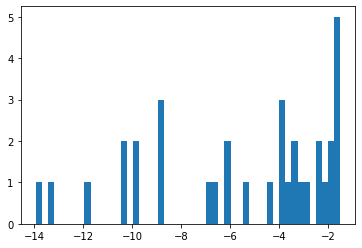

In [ ]:
plt.hist(np.log(scipy.signal.find_peaks(s, prominence = 0)[1]['prominences']), bins = 50)

In [ ]:
prominences

array([0.02057255, 0.03537833, 0.05033098, 0.08395259, 0.12494201,
       0.16186098, 0.18480655, 0.20872486, 0.2243003 , 0.22144391,
       0.19202259, 0.15064146, 0.10420672, 0.05792861, 0.03312496,
       0.02804874, 0.02228555, 0.02192064, 0.01396123])

In [ ]:
period_l_l = []
for eigNum in range(28):
    s = v[:, eigNum]
    firstPeak = scipy.signal.find_peaks(s)[0][0]

    windowSize = 50
    maxShift = 50
    period_l =[]
    for ii in range(D.shape[0] - windowSize - maxShift-2):
        pair = []
        for shift in range(maxShift):
            sig = s[ii:ii+windowSize]
            shift_sig = s[ii+shift:ii+shift+windowSize]
            try:
                pair.append(np.dot(sig, shift_sig))
            except:
                print(ii)
                raise Exception('')

        allpeaks = scipy.signal.find_peaks(np.array(pair))[0]
        try:            
            argmax = [arg for arg in allpeaks if arg > 5][0]            
        except:
            argmax = -1
        period_l.append(argmax)
    print(eigNum)
    period_l_l.append(period_l)
    # plt.plot(period_l)
    # plt.show()    
    # plt.close()
    plt.plot(s)
    plt.savefig('eig/%d.png'%eigNum)
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


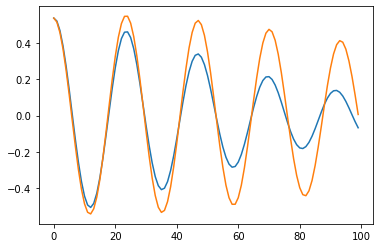

In [ ]:
ii = 200
pair = []
pair_neg = []
for shift in range(windowSize):
    sig = s[ii:ii+windowSize]
    shift_sig = s[ii+shift:ii+shift+windowSize]
    pair.append(np.dot(sig, shift_sig))
    shift_sig = s[ii-shift:ii-shift+windowSize]
    pair_neg.append(np.dot(sig, shift_sig))

scipy.signal.find_peaks(np.array(pair))[0][0]    



In [ ]:
scipy.signal.find_peaks(np.array(pair))[0]


array([24, 47, 70, 92])

In [ ]:
scipy.signal.find_peaks(s)[0][1]

23

(array([15.,  8.,  1.,  2.,  1.,  0.,  2.,  1.,  1.,  3.]),
 array([3.90423090e-05, 1.22094366e-02, 2.43798308e-02, 3.65502251e-02,
        4.87206193e-02, 6.08910136e-02, 7.30614079e-02, 8.52318021e-02,
        9.74021964e-02, 1.09572591e-01, 1.21742985e-01]),
 <a list of 10 Patch objects>)

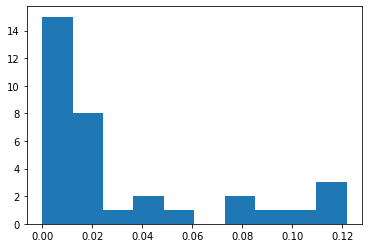

In [ ]:
plt.hist([np.abs(s[x]) for x in scipy.signal.find_peaks(s)[0]])

In [ ]:
protid = '7crb'

parser = PDBParser()
structure = parser.get_structure(protid, "pdb/%s.pdb"%protid)

for model in structure:
    for chain in model:
        if chain.id == 'A':
            break

In [ ]:
f = open("attr/%s_theta.txt"%protid, "w")
f.write("attribute: position\n")
f.write("recipient: residues\n")
for i in range(1, len(chain)+1):
    if i-1 < len(theta):
        f.write("\t" + ":" + str(i) + "\t" + str(theta[i-1]) + "\n")
    else:
        f.write("\t" + ":" + str(i) + "\t" + str(0) + "\n")
f.close()

In [ ]:
len(theta)

590